In [1]:
import sys 
sys.path.append("/home/karen/Documents/GitHub/Muscle_wasting/network")
sys.path.append("/home/karen/Documents/GitHub/Muscle_wasting/database_analysis")
sys.path.append("/home/karen/Documents/GitHub/Muscle_wasting/venv/lib/python3.10/site-packages")
sys.path.append("/home/karen/Documents/GitHub/Muscle_wasting/venv/lib/python3.10/site-packages/networkx")

In [2]:
cd /home/karen/Documents/GitHub/Muscle_wasting

/home/karen/Documents/GitHub/Muscle_wasting


# Analyzing the relevance of the mirnas

Hello Kasia and Pilib, here is my report of the microRNAs


Now we saw with the filtered and whole network
Let's get the mirnas from the relevant PR score and then evaluate them on the whole network

## Background

There are 3 main steps relevant for this report
- DE data
- Network (Transcripor factors)
- Pathways


### DE data
I joined the different rnaseq expression data and using dseq2 got the differentially expressed data. Is important to mention that the DE genes are different than the ones obteined doing the experiments individually (really small overlap). 
We had the comparisons
    - Young vs Old
    - Young vs Middle Age
    - Middle Age vs Old
Therefore is always younger vs older, therefore, up regulared means that it decreases with age, and downregulated that increases with age.

### Network
Using the DE genes, was possible to identify the enriched TF using collectri database and the decoupler library function run_ulm. Using the same database, is possible to build the full network of gene-TF interactions. 
Additionally, using my network, I added the microRNAs as well.

### Pathways
Using msigdb we assigned to each gene the pathways they are involved. We only considered the pathays that were at least slightly enriched. From all the pathways, on this notebook, only the pathways that seem logically involved on sarcopenia are presented:

    - ATP 	
    - MITOCHONDRI 	
    - RESPIRAT 	
    - METABOLI 	
    - OXIDATIVE_PHOSPHORYLATION 	
    - NONALCOHOLIC_FATTY_LIVER 	
    - MUSCLE 	
    - ELECTRON
    
Now, as you can see, the name of the pathways are not compleate, this is because as microcondri I want to include terms as

    - GOBP_MITOCHONDRIAL_ELECTRON_TRANSPORT_NADH_TO_UBIQUINONE
    - GOCC_INNER_MITOCHONDRIAL_MEMBRANE_PROTEIN_COMPLEX
    - HP_ABNORMAL_MITOCHONDRIA_IN_MUSCLE_TISSUE
    - etc
    
All the pathways were added on the network with my software


Now that we have the data about the network, let's see the impact of the microRNAs

In [3]:
import walking_network as wn

In [4]:
import networkx as nx

In [5]:
import pandas as pd
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.colors as mcolors


In [8]:
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cityblock




In [9]:
# Function to ensure all elements are integers
def convert_to_int_list(lst):
    if isinstance(lst, list):
        return [int(x) for x in lst]
    elif isinstance(lst, str):
        string = lst.replace('[','').replace(']','')
        string = string.split(',')
        return [int(x) for x in string]
    else:
        return [lst]
def get_impact_data(df):

    color_data = pd.DataFrame(index=df.index, columns=df.columns)
    
    for col in df.columns:
        for idx in df.index:
            int_list = convert_to_int_list(df.at[idx, col])
            color_data.at[idx, col] = sum(int_list)

    return color_data


def plot_dotplot(df):
    
    # Create new DataFrame for plotting
    plot_data = pd.DataFrame(index=df.index, columns=df.columns)
    size_data = pd.DataFrame(index=df.index, columns=df.columns)
    color_data = pd.DataFrame(index=df.index, columns=df.columns)
    
    for col in df.columns:
        for idx in df.index:
            int_list = convert_to_int_list(df.at[idx, col])
            size_data.at[idx, col] = len(int_list)
            color_data.at[idx, col] = sum(int_list)
    
    # Convert to long format for seaborn
    plot_data = pd.DataFrame({
        'Gene': np.repeat(df.index, df.shape[1]),
        'miRNA': np.tile(df.columns, df.shape[0]),
        'Paths': size_data.values.flatten(),
        'Influence': color_data.values.flatten()
    })
    
    # Define custom colormap
    cmap = LinearSegmentedColormap.from_list('custom', ['red', 'white', 'blue'])

    
    
    # Filter out rows where the size is 0
    plot_data = plot_data[plot_data['Paths'] > 0]

    colors = ['red', 'white', 'blue']
    n_mid = abs(min(plot_data['Influence'])) / (abs(min(plot_data['Influence'])) + max(plot_data['Influence']))
    nodes = [0, n_mid, 1]
    cmap = LinearSegmentedColormap.from_list('custom', list(zip(nodes, colors)))
    
    # Plot using seaborn
    n_mirna= len(size_data.columns) + 1
    n_genes  = len(size_data) + 1
    print('genes', n_genes - 1)
    print('mirnas', n_mirna - 1)
    height_plot = min(655,int(n_genes*.3))

    height_plot = max(10, height_plot)
    sns.set(rc={'axes.facecolor':'lightgray'})
    fig, ax = plt.subplots(figsize=(n_mirna*1.5, height_plot))
    ax.grid(False)


    
    #plt.figure(figsize=(10, height_plot))
    scatter_plot = sns.scatterplot(data=plot_data, x='miRNA', y='Gene', size='Paths', hue='Influence', palette=cmap, sizes=(20, 200))
    scatter_plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    
    # Get the first two and last y-tick positions.
    miny, nexty, *_, maxy = ax.get_yticks()
    
    # Compute half the y-tick interval (for example).
    eps = (nexty - miny) / 2  # <-- Your choice.
    plt.xticks(rotation=90)
    # Adjust the limits.
    ax.set_ylim(maxy+eps, miny-eps)
    #plt.tight_layout()
    plt.show()

In [10]:

def order_length_mirna(df, interest_mirna:str):
    df_sorted = df.copy()
    df_sorted['length'] = df_sorted[interest_mirna].apply(lambda x: len(x) if isinstance(x, list) else 0)
    df_sorted = df_sorted.sort_values(by='length', ascending=False)
    df_sorted = df_sorted.drop(columns=['length'])
    return df_sorted


def order_impact_mirna(df, interest_mirna:str):
    df_sorted = df.copy()
    df_sorted['impact'] = df_sorted[interest_mirna].apply(lambda x: sum(x) if isinstance(x, list) else 0)
    df_sorted = df_sorted.sort_values(by='impact', ascending=False)
    df_sorted = df_sorted.drop(columns=['impact'])
    return df_sorted

In [11]:
# Function to calculate the sum of lengths of lists in a row
def sum_lengths(row):
    return sum(len(lst) for lst in row)

def get_minra_influence(test_mir, df):
    
    test_mir_df = df.T[test_mir]
    test_mir_df  = pd.DataFrame(test_mir_df)
    test_mir_df['length'] = test_mir_df[test_mir].apply(lambda x: len(x)  if isinstance(x, list) else 0)
    test_mir_df = test_mir_df.sort_values(by='length', ascending=False)
    test_mir_df = test_mir_df.drop(columns=['length'])
    return test_mir_df

In [12]:
from sklearn.cluster import SpectralClustering



def get_mirnas_similar_impact(df):
    df_numeric = df.apply(pd.to_numeric, errors='coerce')
    
    # Calculate the pairwise distances between columns
    dist_matrix = pdist(df_numeric.T, metric='cityblock')
    dist_matrix_square = squareform(dist_matrix)
    
    # Create a DataFrame for the distance matrix
    dist_df = pd.DataFrame(dist_matrix_square, index=df_numeric.columns, columns=df_numeric.columns)
    sorted_index = dist_df.mean().sort_values().index  # Sorting by mean distance

    return dist_df.loc[sorted_index, sorted_index]

def plot_similarity_heatmap(sorted_df):
    # Plot the sorted distance matrix as a heatmap
    n_mirnas = len(sorted_df)
    size_l = n_mirnas*0.3
    plt.figure(figsize=(size_l, size_l))
    sns.heatmap(sorted_df, annot=False, cmap='coolwarm')#, linewidths=0.5)#, linecolor='black')
    plt.title('Sorted Distance Matrix Heatmap')
    plt.show()


def cluster_mirnas(dist_matrix_square, n_clusters = 10):
    # Convert distance matrix to similarity matrix (affinity matrix)
    affinity_matrix = np.exp(-dist_matrix_square / dist_matrix_square.std())  # Using Gaussian kernel for similarity
    
    # Apply Spectral Clustering
      # Number of clusters
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    cluster_labels = sc.fit_predict(affinity_matrix)
    
    
    # Print cluster labels
    print("Cluster labels:\n", cluster_labels)
    mirnas = sorted_df.index
    
    mirna_clusters  = pd.DataFrame(cluster_labels, index= mirnas, columns=['Cluster'])
    return  mirna_clusters

We used 2 netwoks here, the original one of 4159 nodes and 14587 edges with all the genes, TF and microRNAs generated, and the second one that is the same network but only the nodes whitin the top 80% of nodes of the pageRank rank. This limit was done given the fact that with that small theshold, from 566 mirnas to 13 mirnas.

## MicroRNAs influence on genes

Starting on each of those 13 mirnas, we cover all the accesible paths from that node (each edge visited only once), if the influence is inhibition, it applies a -1, if it is activation, +1. Doing that, we can register in each time the mirna visitis a particular gene, see if the mirna has a positive or negative interaction.
Each node has a list of (1,-1), the length of the list means the amount of times the mirna is able to reach the node.
For each mirna, you can see the impact on each gene and looks like this:

In [13]:
df = pd.read_csv(f"mirna_influence_147_genes_impact.csv", index_col=0)

In [14]:
df.drop(columns=['final'],inplace=True)

**interesting**,
hsa-miR-21-5p and hsa-miR-210-3p behaive really similar but is not the same, and hsa-miR-145-5p and hsa-miR-143-3p are similar too.
Interesting is that (hsa-miR-21-5p and hsa-miR-210-3p) and (hsa-miR-145-5p and hsa-miR-143-3p) behaive almost opposite!!!

In [15]:
df = df.T

This is the "next section"! 

### Up or down reculated

#### Young vs Old

See the influcne of the genes that are down regualted in Young respect to old, this means that they INCREASE WITH AGE.
Therefore, what we would like to see is more big red dots that means that the microRNA inhibits that gene.

Get the up or down reluation


This are only the 1381 genes that are down regulated and then the 589 genes that are up regulated

In [68]:
redulation_df = pd.read_csv('data/RNAseq_abundance_adjusted_combat_inmose_all_lfc.csv', index_col=0)
redulation_df

,yo,ym,mo,ml_c,ml_s
gene,,,,,
CFH,-0.266518,NaN,NaN,NaN,NaN
SEMA3F,-4.102241,NaN,-3.743393,NaN,NaN
CFTR,-3.346279,NaN,-4.146497,NaN,NaN
RAD52,-0.556749,NaN,NaN,NaN,NaN
MYH16,7.573264,NaN,5.626051,NaN,NaN
...,...,...,...,...,...
Unnamed: 34254,-2.382550,NaN,NaN,NaN,NaN
Unnamed: 34260,-3.038266,NaN,NaN,NaN,NaN
Unnamed: 34273,-2.750935,NaN,-4.449913,NaN,NaN


In [31]:
x = redulation_df[redulation_df['yo']>2]

In [33]:
x = x[x['yo']>2]
x

,yo,ym,mo,ml_c,ml_s
gene,,,,,
ABCC2,3.764793,8.064190,-4.299398,NaN,NaN
TG,4.547485,3.786372,NaN,NaN,NaN
FKBP6,2.330406,6.556816,-4.226409,NaN,NaN
CPA1,6.863082,5.114801,NaN,NaN,NaN
CDC45,2.481670,6.650516,-4.168846,NaN,NaN
...,...,...,...,...,...
CNTNAP3P5,3.692819,7.076147,-3.383328,NaN,NaN
PRAMEF18,5.067009,3.899639,NaN,NaN,NaN
CCDC28A-AS1,3.279130,3.076062,NaN,NaN,NaN


In [34]:
x[x['mo'].notnull()]

,yo,ym,mo,ml_c,ml_s
gene,,,,,
ABCC2,3.764793,8.064190,-4.299398,NaN,NaN
FKBP6,2.330406,6.556816,-4.226409,NaN,NaN
CDC45,2.481670,6.650516,-4.168846,NaN,NaN
MIOX,2.822945,10.151222,-7.328277,NaN,NaN
GLRA2,2.803255,6.111204,-3.307949,NaN,NaN
...,...,...,...,...,...
Unnamed: 33159,3.078745,8.380194,-5.301449,NaN,NaN
STMN1P1,3.343519,9.692991,-6.349472,NaN,NaN
Unnamed: 33285,2.739045,6.671926,-3.932880,NaN,NaN


In [69]:
redulation_df['curve_type'] = ['00']*len(redulation_df)
curves = []
for gene, row in redulation_df.iterrows():
    curve_type = ['X','X']
    if pd.isna(row['ym']):
        curve_type[0]='A'
    elif row['ym']>0:
        curve_type[0]='B'
    elif row['ym']<0:
        curve_type[0]='C'
    if pd.isna(row['mo']):
        curve_type[1]='A'
    elif row['mo']>0:
        curve_type[1]='B'
    elif row['mo']<0:
        curve_type[1]='C'
    if curve_type == ['C','B'] or curve_type == ['B','C']: 
        if pd.isna(row['yo']):
            curve_type.append('-A')
        elif row['yo']>0:
            curve_type.append('-B')
        else:
            curve_type.append('-C')
    curve_type = ''.join(curve_type)
    curves.append(curve_type)
redulation_df['curve_type'] = curves
redulation_df

,yo,ym,mo,ml_c,ml_s,curve_type
gene,,,,,,
CFH,-0.266518,NaN,NaN,NaN,NaN,AA
SEMA3F,-4.102241,NaN,-3.743393,NaN,NaN,AC
CFTR,-3.346279,NaN,-4.146497,NaN,NaN,AC
RAD52,-0.556749,NaN,NaN,NaN,NaN,AA
MYH16,7.573264,NaN,5.626051,NaN,NaN,AB
...,...,...,...,...,...,...
Unnamed: 34254,-2.382550,NaN,NaN,NaN,NaN,AA
Unnamed: 34260,-3.038266,NaN,NaN,NaN,NaN,AA
Unnamed: 34273,-2.750935,NaN,-4.449913,NaN,NaN,AC


In [75]:
x = redulation_df[redulation_df['curve_type'].str.contains('-')]
x[x['curve_type'].str.contains('-B')]

,yo,ym,mo,ml_c,ml_s,curve_type
gene,,,,,,
ABCC2,3.764793,8.064190,-4.299398,NaN,NaN,BC-B
NDUFB4,5.239622,-4.034287,9.273909,0.474573,0.071956,CB-B
FKBP6,2.330406,6.556816,-4.226409,NaN,NaN,BC-B
CDC45,2.481670,6.650516,-4.168846,NaN,NaN,BC-B
MIOX,2.822945,10.151222,-7.328277,NaN,NaN,BC-B
...,...,...,...,...,...,...
Unnamed: 33159,3.078745,8.380194,-5.301449,NaN,NaN,BC-B
STMN1P1,3.343519,9.692991,-6.349472,NaN,NaN,BC-B
Unnamed: 33285,2.739045,6.671926,-3.932880,NaN,NaN,BC-B


In [79]:
influence = get_impact_data(df)
influence

,hsa-miR-21-5p,hsa-miR-210-3p,hsa-miR-145-5p,hsa-miR-143-3p,hsa-miR-128-3p,hsa-miR-29a-3p,hsa-miR-29b-3p,hsa-miR-181b-5p,hsa-miR-203a-3p,hsa-miR-29c-3p,...,hsa-miR-19a-3p,hsa-miR-376c-3p,hsa-miR-199a-3p,hsa-miR-429,hsa-miR-126-3p,hsa-miR-200a-3p,hsa-miR-221-3p,hsa-miR-182-5p,hsa-miR-148a-3p,hsa-miR-103a-3p
MYC,7,-5,-22,-9,-5,-10,-10,7,-5,-9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TERT,1,1,-14,-9,1,-9,-9,-1,1,-9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SPI1,-1,-1,-6,-3,-1,-3,-3,1,-1,-3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BGLAP,0,0,0,0,0,0,0,2,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STAT5A,1,-3,6,3,-3,3,3,-1,-3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LAMC1,4,4,-8,-4,4,-4,-4,4,4,-4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ESAM,4,4,-8,-4,4,-4,-4,4,4,-4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ITGA2,4,4,-8,-4,4,-4,-4,4,4,-4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PEG3,4,4,-8,-4,4,-4,-4,4,4,-4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:

for col in df.columns:
    if col != 'yo':
        influence[col] = influence[col]*df['yo']
influence

KeyError: 'yo'

In [106]:
len(influence)

3456

In [109]:
influence = influence.dropna(how='all')
influence.drop(columns=['yo'], inplace=True)
influence.dropna(how='all', axis=1)

,hsa-miR-21-5p,hsa-miR-210-3p,hsa-miR-145-5p,hsa-miR-143-3p,hsa-miR-128-3p,hsa-miR-29a-3p,hsa-miR-29b-3p,hsa-miR-181b-5p,hsa-miR-203a-3p,hsa-miR-29c-3p,...,hsa-miR-19a-3p,hsa-miR-376c-3p,hsa-miR-199a-3p,hsa-miR-429,hsa-miR-126-3p,hsa-miR-200a-3p,hsa-miR-221-3p,hsa-miR-182-5p,hsa-miR-148a-3p,hsa-miR-103a-3p
MYC,-37.351011,26.679294,117.388892,48.022729,26.679294,53.358587,53.358587,-37.351011,26.679294,48.022729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IL3,-16.076763,-8.038382,16.076763,8.038382,-8.038382,8.038382,8.038382,-24.115145,-8.038382,8.038382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PLAG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IL12B,7.396321,17.258082,-4.930881,-2.46544,17.258082,-2.46544,-2.46544,2.46544,17.258082,-2.46544,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PDLIM7,-0.37985,-0.37985,0.7597,-0.37985,-0.37985,-0.37985,-0.37985,-1.13955,-0.37985,-0.37985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CDX1,13.695067,13.695067,-27.390134,-13.695067,13.695067,-13.695067,-13.695067,13.695067,13.695067,-13.695067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOXC4,-10.80173,-10.80173,21.60346,10.80173,-10.80173,10.80173,10.80173,-10.80173,-10.80173,10.80173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TACSTD2,-10.378699,-10.378699,20.757399,10.378699,-10.378699,10.378699,10.378699,-10.378699,-10.378699,10.378699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ESAM,2.4065,2.4065,-4.812999,-2.4065,2.4065,-2.4065,-2.4065,2.4065,2.4065,-2.4065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
mir_compatibility = influence.sum()
mir_compatibility = mir_compatibility.sort_values(ascending=False)

In [116]:
pd.DataFrame(mir_compatibility).to_csv('mirna_score_DE_influence.csv')

In [141]:
mir_compatibility.keys

<bound method Series.keys of hsa-miR-145-5p     1977.100871
hsa-miR-155-5p      1366.15519
hsa-miR-569        1347.836352
hsa-miR-124-3p      1064.31222
hsa-miR-193a-5p    1053.849257
                      ...     
hsa-miR-9-3p      -1017.231276
hsa-miR-548d-5p   -1017.478917
hsa-miR-27a-5p    -1017.478917
hsa-miR-137        -1021.47308
hsa-miR-141-3p     -1031.88407
Length: 147, dtype: object>

In [ ]:
influence_quanity_dict = {}
for col in influence.columns:
    influence_quanity_dict[col] = len(influence[influence[col]>0])/len(influence)
influence_quanity_dict

In [132]:
influence_quanity_df =pd.DataFrame.from_dict(influence_quanity_dict,  orient='index')
influence_quanity_df.sort_values(by=[0], ascending=False)

,0
hsa-miR-155-5p,0.587902
hsa-miR-569,0.584121
hsa-miR-200c-3p,0.544423
hsa-miR-193a-5p,0.544423
hsa-miR-124-3p,0.536862
...,...
hsa-miR-126-3p,0.003781
hsa-miR-1-3p,0.001890
hsa-miR-133b,0.001890
hsa-miR-103a-3p,0.001890


In [ ]:
mirnas_good = list(influence_quanity_df[influence_quanity_df[0]>0.5].index)

In [133]:
influence_quanity_df.to_csv('mirna_score_DE_influence_2.csv')

In [144]:
mir_compatibility.index

Index(['hsa-miR-145-5p', 'hsa-miR-155-5p', 'hsa-miR-569', 'hsa-miR-124-3p',
       'hsa-miR-193a-5p', 'hsa-miR-7-5p', 'hsa-miR-10a-5p', 'hsa-miR-24-3p',
       'hsa-miR-31-5p', 'hsa-miR-26a-5p',
       ...
       'hsa-miR-218-5p', 'hsa-miR-150-5p', 'hsa-miR-450a-5p', 'hsa-miR-10b-5p',
       'hsa-miR-22-3p', 'hsa-miR-9-3p', 'hsa-miR-548d-5p', 'hsa-miR-27a-5p',
       'hsa-miR-137', 'hsa-miR-141-3p'],
      dtype='object', length=147)

In [ ]:
order_mirs = [mir for mir in mir_compatibility.index if mir in mirnas_good]
order_mirs

genes 43
mirnas 20


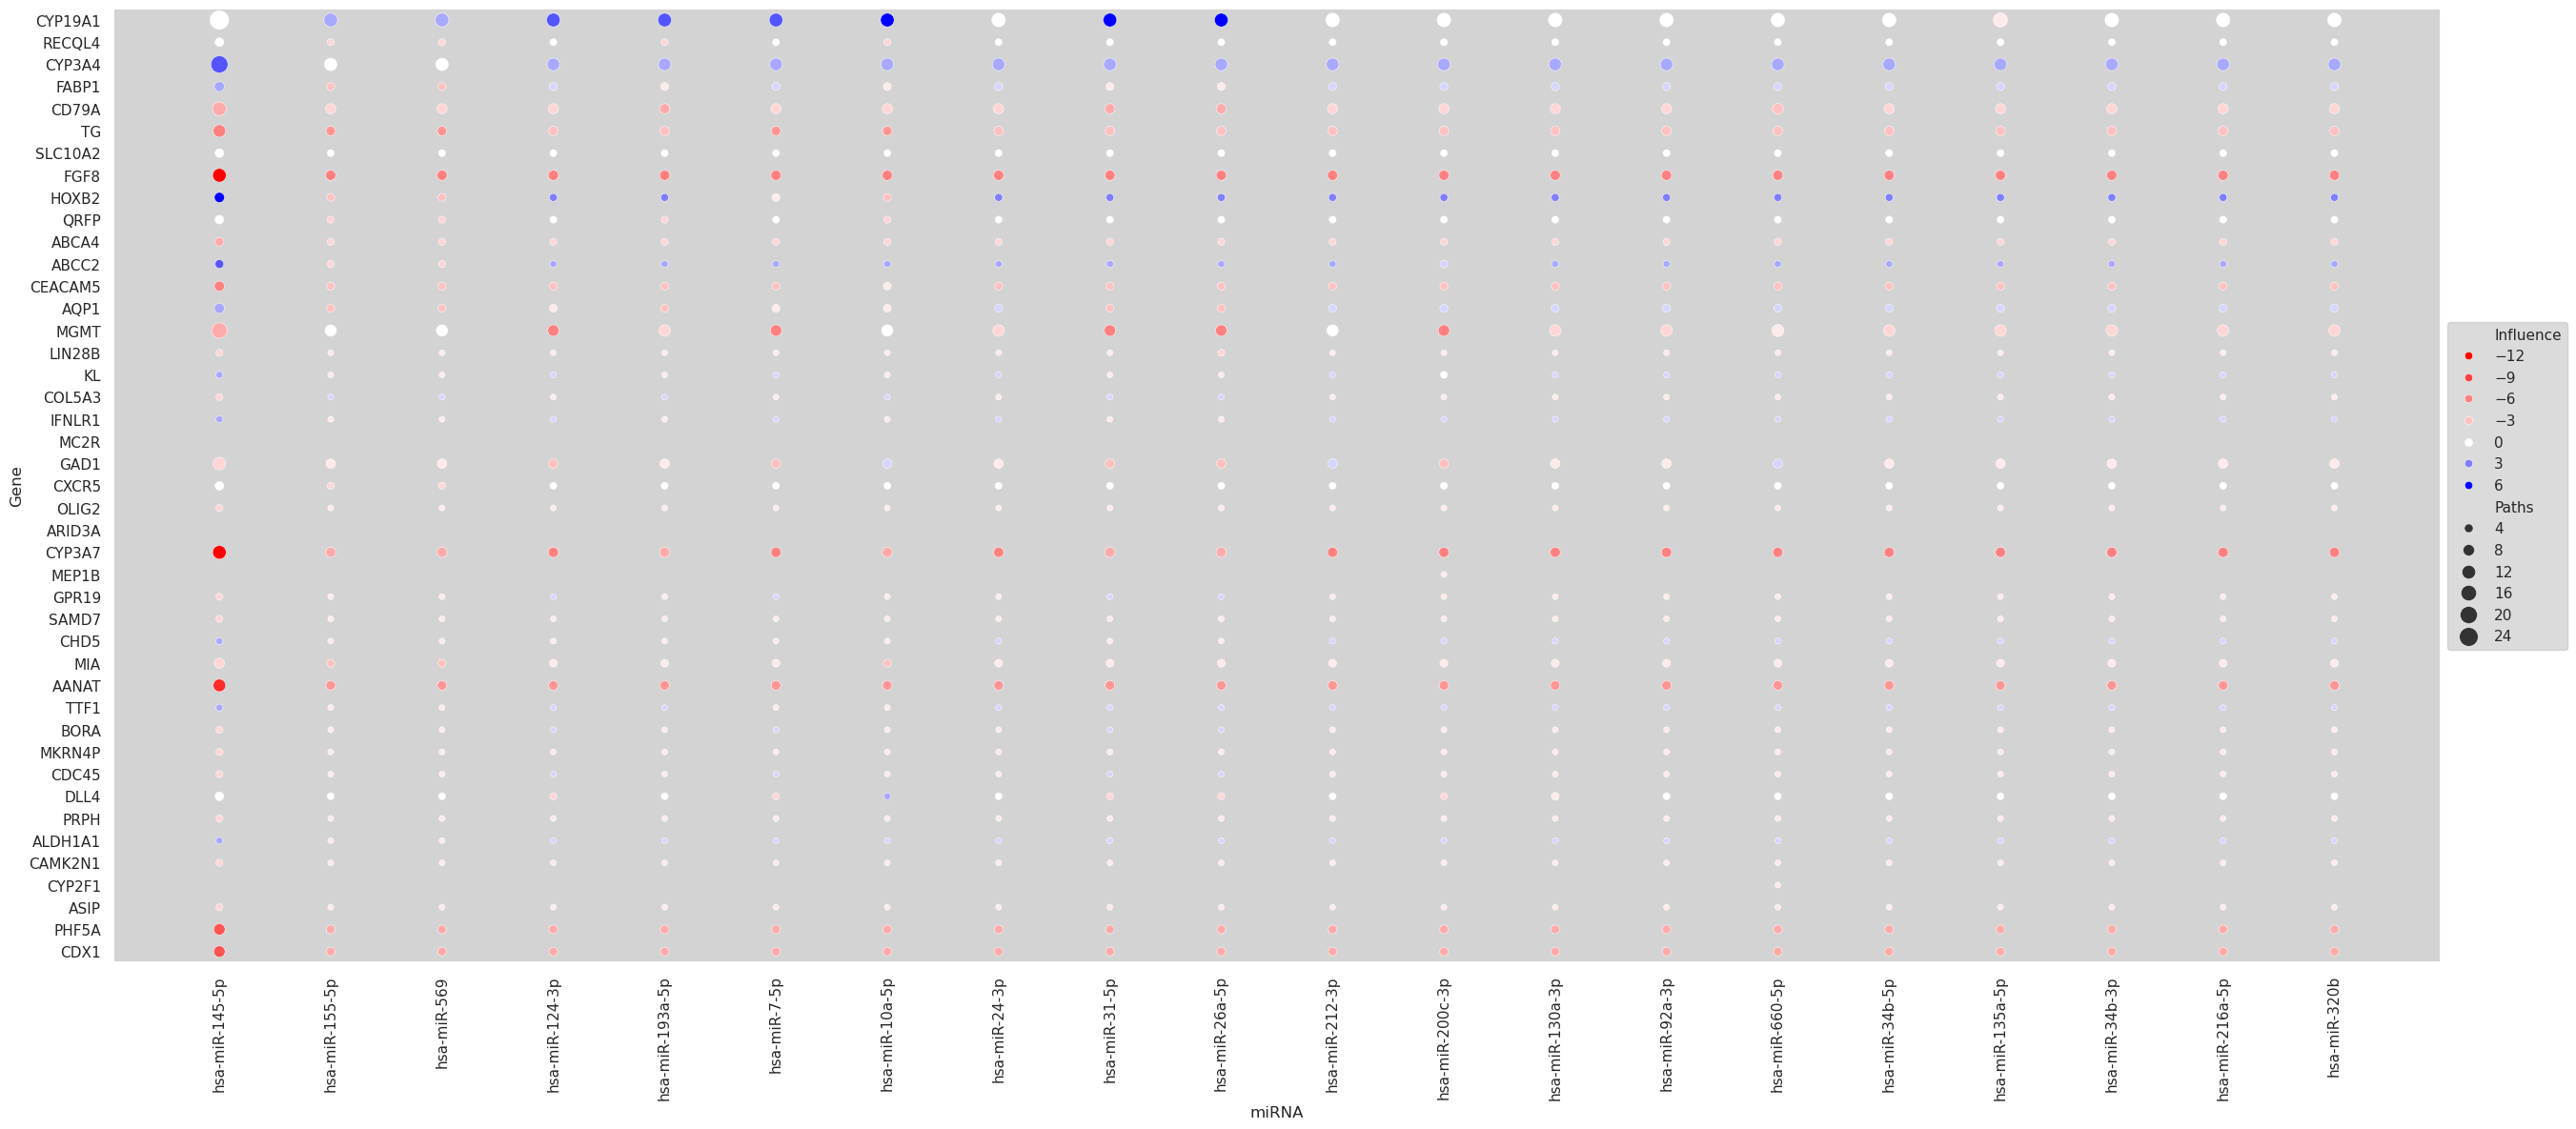

genes 43
mirnas 25


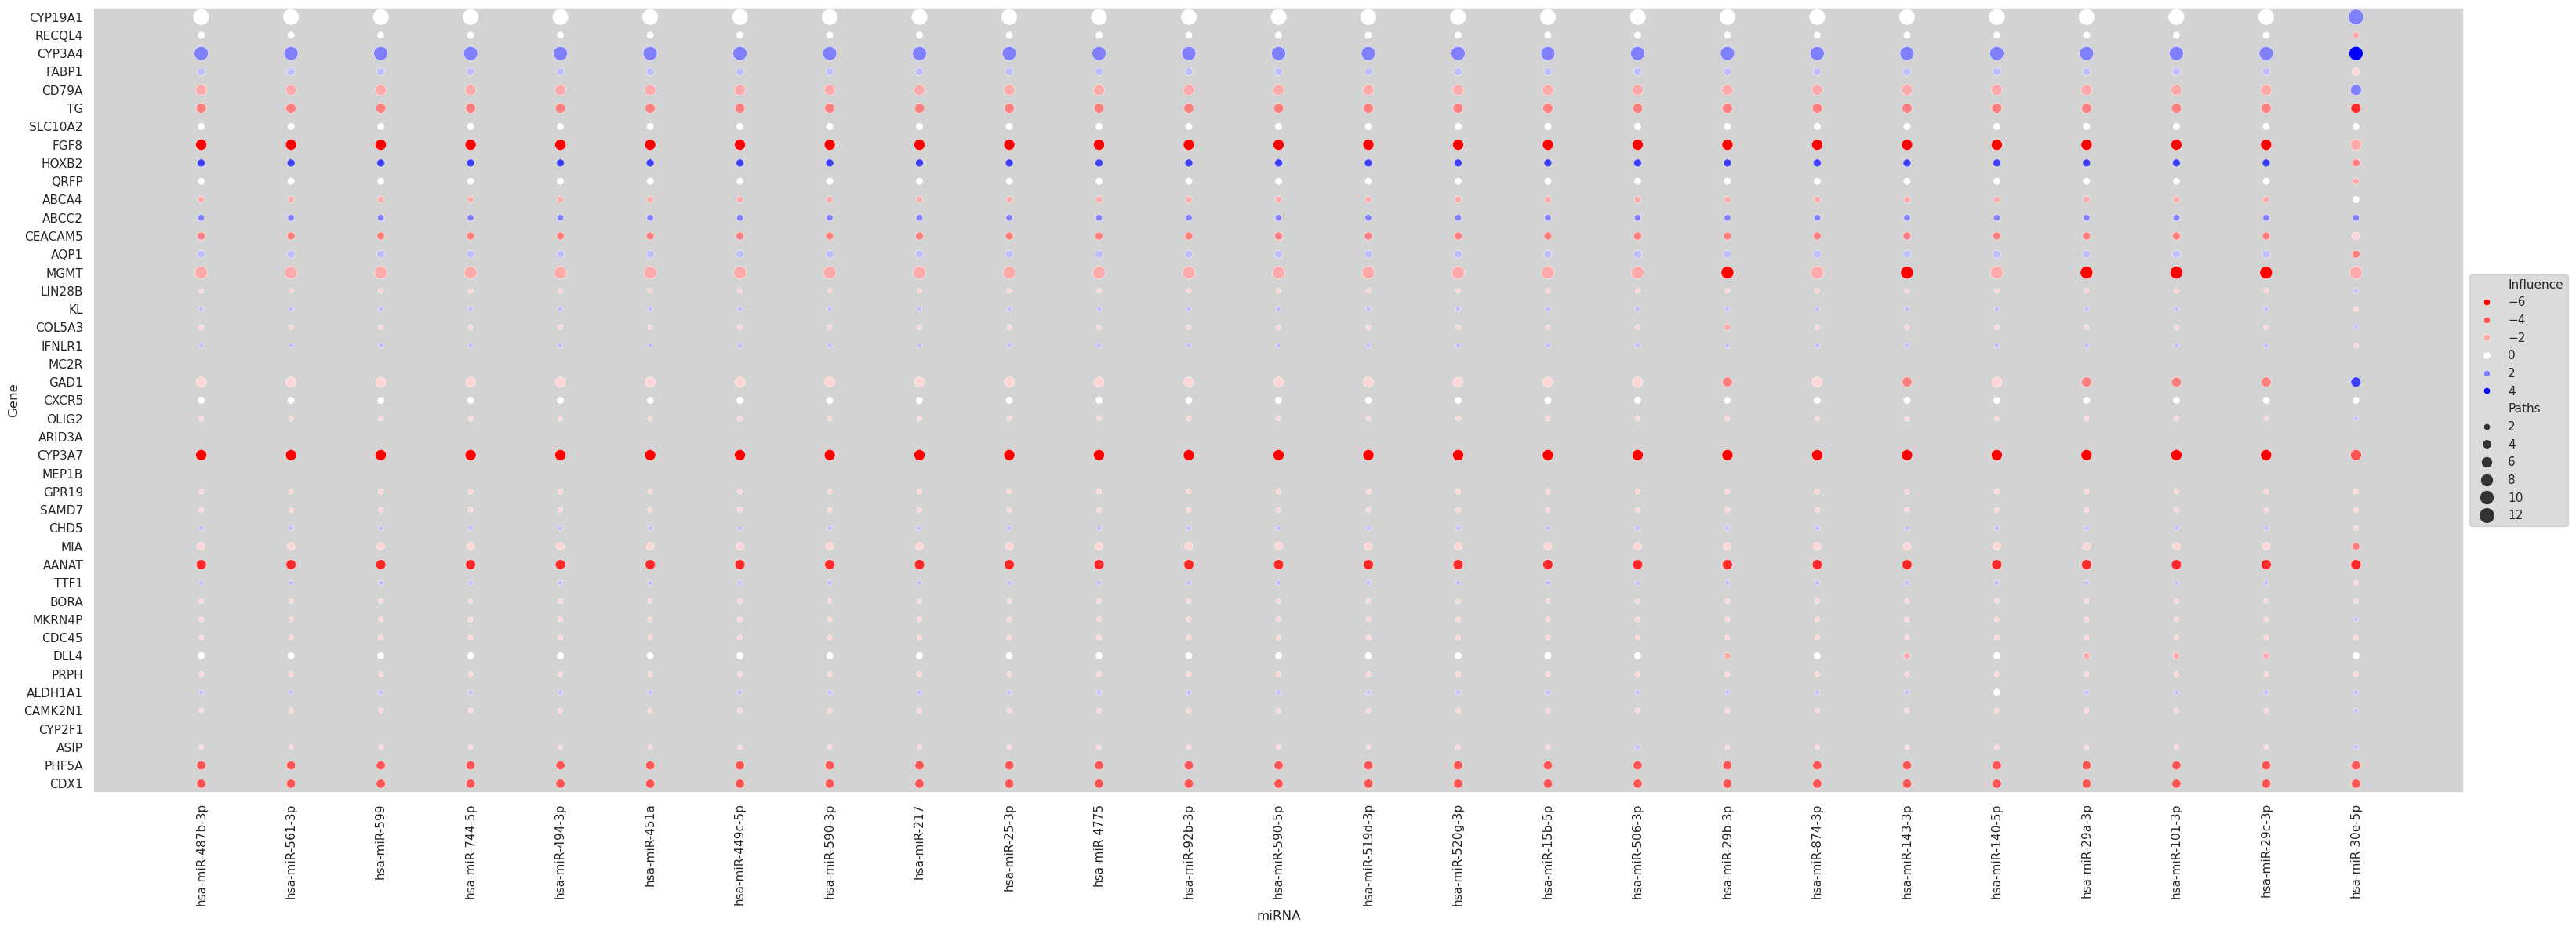

In [153]:
df_0 = df_up_yo[order_mirs].T
df_1 = df_0[:20].T
df_2 = df_0[20:].T
plot_dotplot(df_1)
plot_dotplot(df_2)

### Pathways affected

Now, usig those 13 microRNA nodes in the whole network, we start on that mirna and do on 5 steps, 10 paths, doing that we registered the paths that the path visits (I am still working on how to describe this with words) 
But basically we have record of all the pathways genes alterated. 

In [45]:
mirPaths={}
for mir in miR_nodes:
    p = wn.get_pathways(graph=whole_network, mirna=mir, n_distance=steps, sample_size=10)
    unique_set = set(tuple(lst) for lst in p)
    
    # Convert back to a list of lists
    unique_list = [list(tpl) for tpl in unique_set]
    mirPaths[mir]=unique_list


In [ ]:
mirPaths

In [47]:
mirInfluence={}
for mir, path in mirPaths.items():
    influence = wn.get_influence(whole_network, path)
    mirInfluence[mir]=influence
#mirInfluence

In [48]:
mir_pathway_influence = {}
for mir, influence_data in  mirInfluence.items():
    pi = wn.evaluate_pathway_influence(influence_data)
    mir_pathway_influence[mir]=pi

mir_de_influence = {}
for mir, influence_data in  mirInfluence.items():
    pi = wn.evaluate_de_influence(influence_data)
    mir_de_influence[mir]=pi


We recoreded the times it gets on a gene on that pathway. There are registered on the table bellow. Since there are many pathways that we don't consider, there is a column called Different_pathways that shows the unique pathways the mirna affected somehow on those 5 steps, Total is the sum of all (considerered or not) and participation is the sum of those that are considered.

In [49]:
mir_pathway_influence_df = pd.DataFrame(mir_pathway_influence).T
#mir_pathway_influence_df = mir_pathway_influence_df.drop(columns=["Different_pathways", "Total"])
mir_pathway_influence_df['participation'] = mir_pathway_influence_df.drop(columns=["Different_pathways", "Total"]).sum(axis=1)
mir_pathway_influence_df

,ATP,MITOCHONDRI,RESPIRAT,METABOLI,OXIDATIVE_PHOSPHORYLATION,NONALCOHOLIC_FATTY_LIVER,MUSCLE,ELECTRON,Different_pathways,Total,participation
hsa-miR-223,0,0,0,0,0,0,0,0,0,0,0
hsa-miR-21-5p,0,0,2,1,1,0,1,0,14,120,5
hsa-miR-210-3p,0,0,0,0,0,1,1,0,6,56,2
hsa-miR-122,0,0,0,0,0,0,0,0,0,0,0
hsa-miR-145-5p,0,1,0,5,0,0,1,0,9,152,7
...,...,...,...,...,...,...,...,...,...,...,...
hsa-miR-1283,0,0,0,0,0,1,0,0,2,16,1
hsa-miR-335-3p,0,0,0,0,0,0,0,0,0,0,0
hsa-miR-195-3p,0,0,0,0,0,0,0,0,0,0,0
hsa-miR-204-3p,0,0,0,0,0,0,0,0,0,0,0


And here is the same data but on a heatmap. The most... brown(?) is the more times it land on that pathway.

<Axes: >

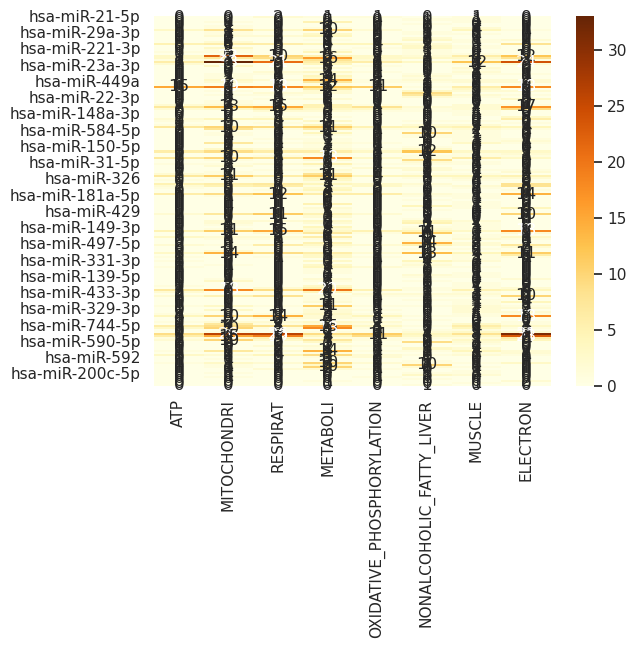

In [50]:
mir_pathway_influence_df_n0=mir_pathway_influence_df[mir_pathway_influence_df['participation']>0]
mir_pathway_influence_df_n0 = mir_pathway_influence_df_n0.drop(columns=["Different_pathways", "Total", "participation"])

sns.heatmap(mir_pathway_influence_df_n0, cmap="YlOrBr", annot=True)

### Mirnas that affect differential expressed genes



Some micrornas, on that 5 step path, affect DE genes on Young vs Old, Young vs Middle Age and Middle age vs Old. 

In [51]:
mir_de_influence_df = pd.DataFrame(mir_de_influence).T


Here are the mirnas que affect DE genes and how many of those genes it affects. 

In [52]:
mirs_all_infliences = mir_de_influence_df[(mir_de_influence_df['ym']>0)|(mir_de_influence_df['mo']>0)|(mir_de_influence_df['yo']>0)]
mirs_all_infliences

,m_l,m_s,yo,ym,mo
hsa-miR-21-5p,0,0,8,1,3
hsa-miR-210-3p,0,0,6,0,2
hsa-miR-145-5p,0,0,8,1,5
hsa-miR-224-5p,0,0,1,0,0
hsa-miR-93-5p,0,0,2,0,0
...,...,...,...,...,...
hsa-miR-515-5p,0,0,1,0,0
hsa-miR-301b-5p,0,0,1,0,1
hsa-miR-922,0,0,1,0,0
hsa-miR-144-5p,0,0,1,0,0
